In [105]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Задача 6

По условию нам дан гаусовский процесс $X_t, t\in R$ с функцией ковариаций и средним:

$$
a(X_t) = 0, cov(X_s, X_t) = e^{(s - t)^{2}/2}.
$$

Надо посчитать $E (X_{t} | X_{t_{1}}, \ldots, X_{t_{n}}), D (X_{t} | X_{t_{1}}, \ldots, X_{t_{n}}).$ Для этого нам потребуется посчитать сначала условную плотность, используем для этого формулу:
<font size="2">
$$\rho_{(X_{t}|X_{t_{1}},\ldots, X_{t_{n}})} = \frac{f_{(X_{t}, X_{t_{1}}, \ldots, X_{t_{n}})}}{f_{(X_{t_{1}}, \ldots, X_{t_{n}})}}.
$$
</font>

Плотность гаусовского вектора размерности $n$ c матрицей ковариаций $\Sigma$ и средним 0:

$$
\rho(x) = \frac{e^{-1/2 \cdot \langle \Sigma^{-1}x, x\rangle}}{(2\pi)^{n/2} \sqrt{det \Sigma}}.
$$

Логарифм от условной плотности:
$$
\log{\rho_{(X_t|X_{t_1}, \ldots, X_{t_n})}(x\ |\ x_1, \ldots, x_n)} =  \log{\rho_{(X, X_{t_1}, \ldots, X_{t_n})}(x,x_1, \ldots, x_n)} - log{\rho_{(X{t_1}, \ldots, X_{t_n})}(x_1, \ldots, x_n)} = -1/2 \cdot \overline{X}^{T} \Sigma^{-1} \overline{X} - \log( (2\pi)^{n/2} \sqrt{det \Sigma})\ -
$$
$$
- \log{\rho_{(X_{t_1}, \ldots, X_{t_n})}(x_1, \ldots, x_n)},
$$

где $\overline{X} = \begin{pmatrix} x\\x_1\\ \vdots \\x_n \end{pmatrix},$
$
\Sigma = \begin{pmatrix} 
cov(X_t, X_t) & cov(X_{t}, X_{t_1}) & \ldots & cov(X_{t}, X_{t_n}) \\ 
cov(X_{t_1}, X_{t}) & cov(X_{t_1}, X_{t_1}) & \ldots & cov(X_{t_1}, X_{t_n}) \\ 
\vdots & \vdots & \ddots & \vdots\\
cov(X_{t_n}, X_{t}) & cov(X_{t_n}, X_{t_1}) & \ldots & cov(X_{t_n}, X_{t_n})
\end{pmatrix}.
$

При фиксированных значениях $X_{t_1}, \ldots, X_{t_n}$ второе и третье слагаемое в логарифме условной плотности влияет только на аддитивную константу, поэтому нам достаточно посчитать только первое слагаемое. Обозначим 
$
\Sigma^{-1} :=
\begin{pmatrix}
\sigma_{00} & \ldots & \sigma_{n0} \\
\vdots & \ddots & \vdots \\
\sigma_{n0} & \ldots & \sigma_{nn}
\end{pmatrix}.
$
Имеем:
$$
-1/2 \cdot \overline{X}^{T} \Sigma^{-1} \overline{X} = 
-1/2 \cdot
\begin{pmatrix}
x\cdot \sigma_{00} + \sum_{i = 1}^{n} x_i \cdot \sigma_{i0}, & 
x\cdot \sigma_{01} + \sum_{i = 1}^{n} x_i \cdot \sigma_{i1}, &
\ldots, &
x\cdot \sigma_{0n} + \sum_{i = 1}^{n} x_i \cdot \sigma_{in}
\end{pmatrix}
\cdot
\begin{pmatrix}
x \\
x_1 \\
\vdots \\
x_n
\end{pmatrix} = 
$$
$$
= -1/2( x^2 \cdot \sigma_{00} + 2x \sum_{i = 1}^{n} x_i \cdot \sigma_{i0} + C(x_1, \ldots, x_n)).
$$
Тогда:
<font size="3">
$$\rho_{(X_t, X_{t_1}, \ldots, X_{t_n})}(x|x_1, \ldots, x_n) = \overline{C} \cdot e^{-\frac{1}{2 \sigma_{00}}\left(x + \frac{\sum_{i = 1}^{n} x_i \cdot \sigma_{i0}}{\sigma_{00}}\right) ^ 2}
$$
</font>

Таким образом, $X_t| X_{t_1}, \ldots , X_{t_n} \sim \mathscr{N}\left( -\frac{\sum_{i = 1}^{n} x_i \cdot \sigma_{i0}}{\sigma_{00}}, \frac{1}{\sigma_{00}}\right)$ и предсказанием будет $-\frac{\sum_{i = 1}^{n} x_i \cdot \sigma_{i0}}{\sigma_{00}}.$

Напишем необходимые функции для вычисления целевой функции и вычисления предсказания. Чтобы свести к модели с нулевой функцией среднего, вычтем из всех значений среднее, а затем добавим его к оценке матожидания $X_t$.

In [11]:
def calc_f(x, a=0.2, b=0.5, c=2):
    return np.log(1 + x) + a * x + b * np.sin(c * x)

In [20]:
def predict(X, T, t):
    
    def calc_mean(X, sigma):
        return -1. * np.sum(X * sigma[1:, 0])/sigma[0, 0]
    
    def calc_variance(sigma):
        return 1./sigma[0,0]
    
    mean = np.mean(X)
    X = X - mean
    n = len(T) + 1
    times = np.append([t], T)
    sigma = np.matrix(np.exp(-(times.reshape((len(times), 1)) - times) ** 2 / 2.))
    sigma = sigma.getI()
    return mean + calc_mean(X, sigma), calc_variance(sigma)

In [61]:
def show_graphic_with_prediction(sample_size, prediction_size,a,b,c,function_precision=1000, uniform=True, scale=20):
    if uniform:
        T = scs.uniform.rvs(loc=0,scale=scale, size=sample_size)
    else:
        T = np.linspace(0, scale, sample_size)
    T_2 = np.linspace(-0.1, scale + 0.3, prediction_size) 
    X = calc_f(T,a=a,b=b,c=c)
    plt.figure(figsize=(19,9))
    plt.xlim((-1,scale+1))
    plt.ylim((-1, max(X) + 1))
    plt.scatter(T, X, color='black', label='sample')
    plt.plot(T_2, [predict(X, T, t)[0] for t in T_2], color='red', label='prediction')
    plt.fill_between(T_2, [predict(X, T, t)[0] - 3 * predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + 3 * predict(X, T, t)[1] for t in T_2], alpha=0.05, \
                     label='3 sigma confidence interval')
    plt.fill_between(T_2, [predict(X, T, t)[0] - 2 * predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + 2 * predict(X, T, t)[1] for t in T_2], alpha=0.1, \
                     label='2 sigma confidence interval')
    plt.fill_between(T_2, [predict(X, T, t)[0] - predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + predict(X, T, t)[1] for t in T_2], alpha=0.23, label='1 sigma confidence interval')
    plt.plot(np.linspace(0, scale, function_precision), \
             calc_f(np.linspace(0, scale, function_precision),a=a,b=b,c=c),label='function') 
    plt.legend()
    title = "Prediction for f(x) = log(1+x)+ " + str(a) + "* x + " + str(b) + "*sin(" + str(c) + "* x)"
    plt.title(title +  ", uniform = " + str(uniform))
    plt.show()

Теперь можем построить графики предсказания и доверительного интервала для разных случаев выбора моментов времени и параметров.

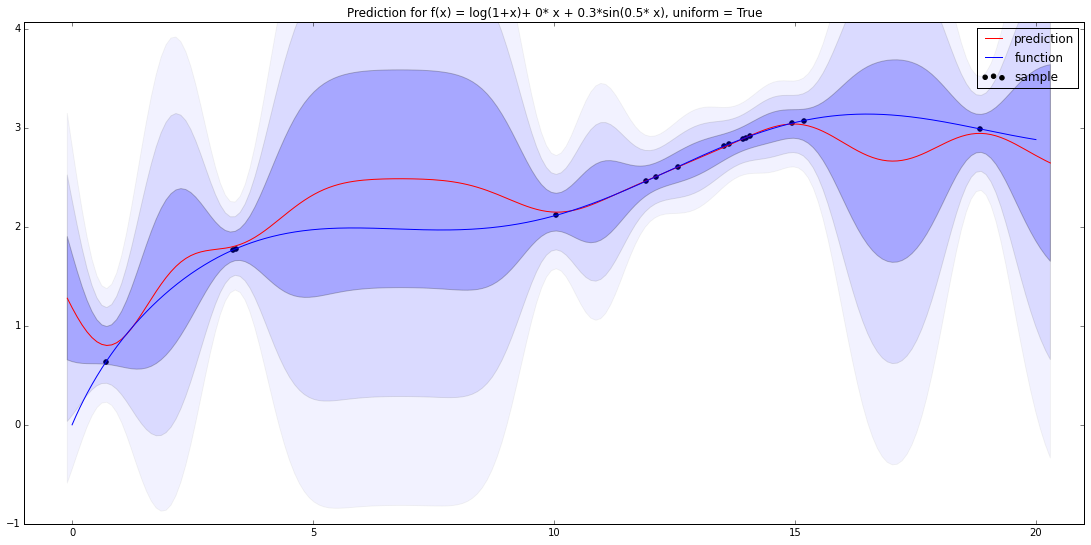

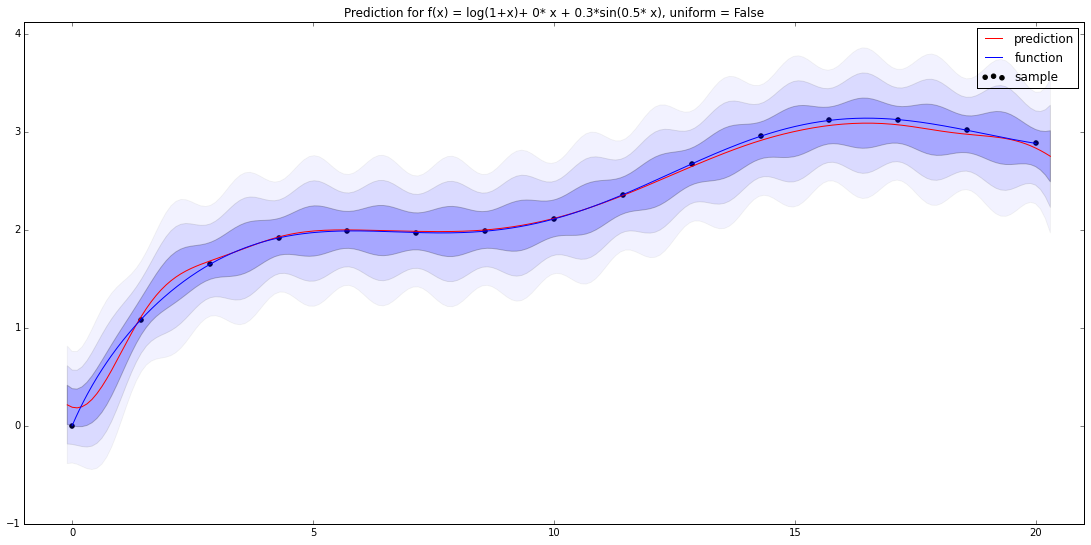

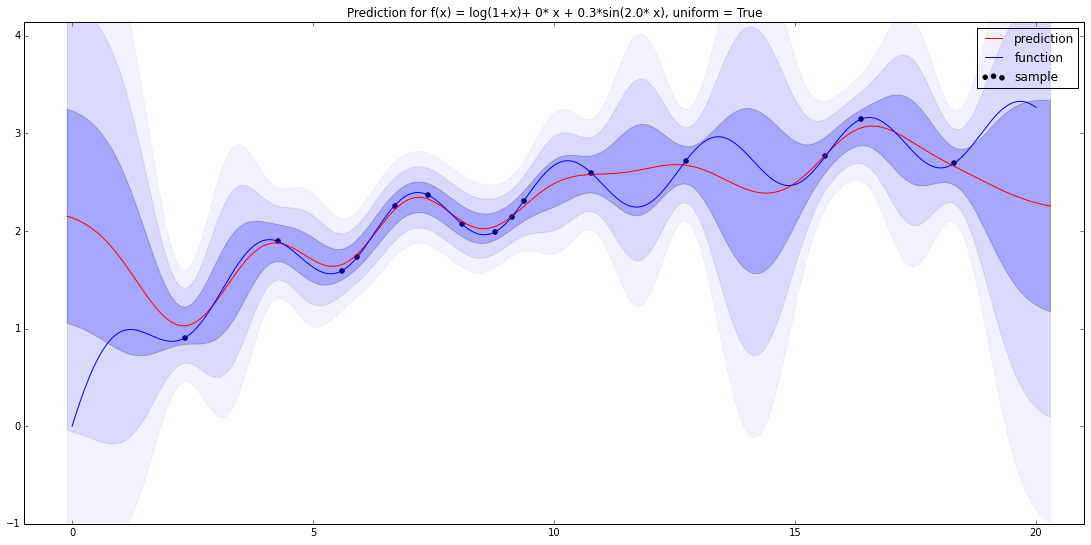

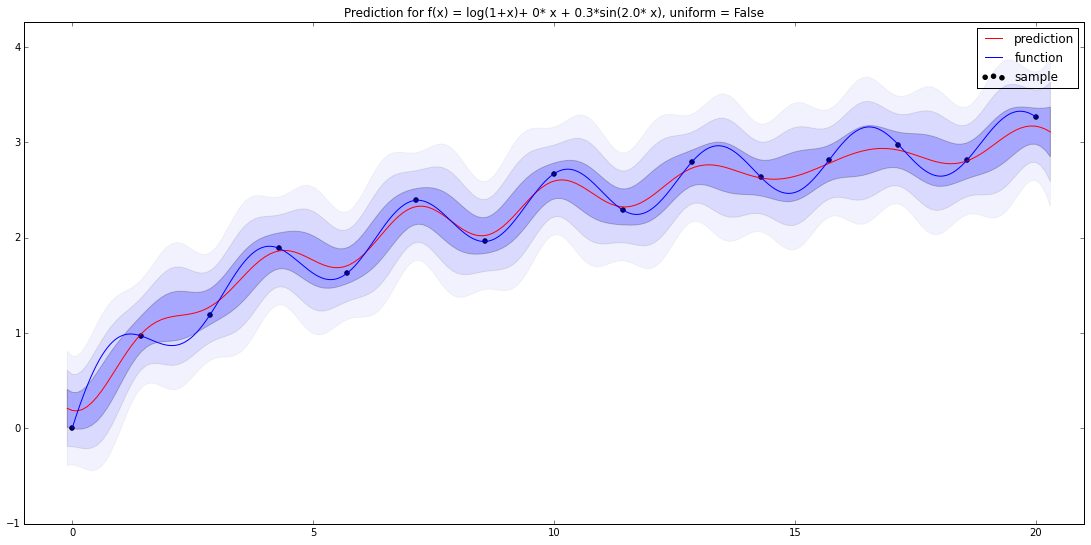

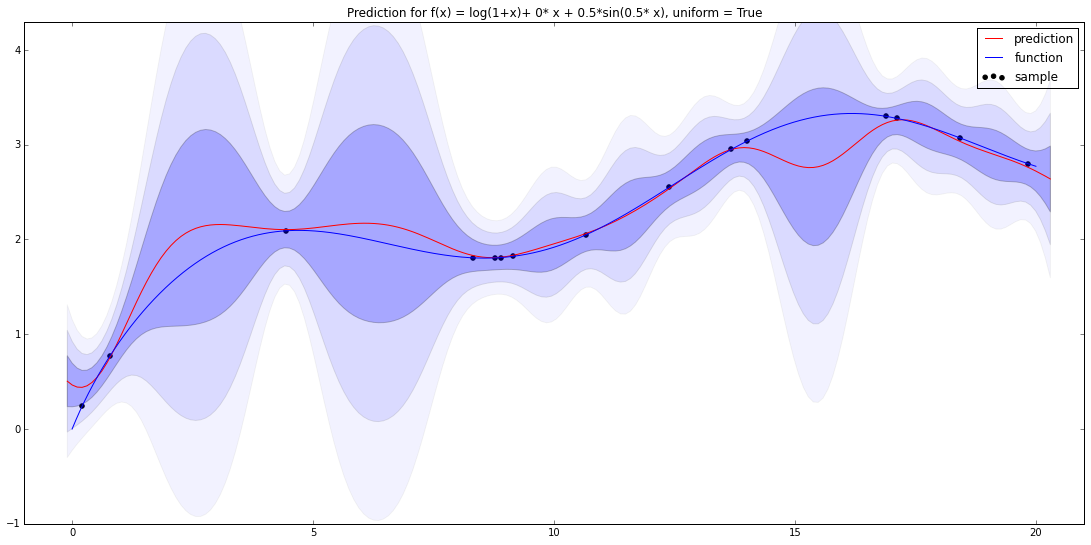

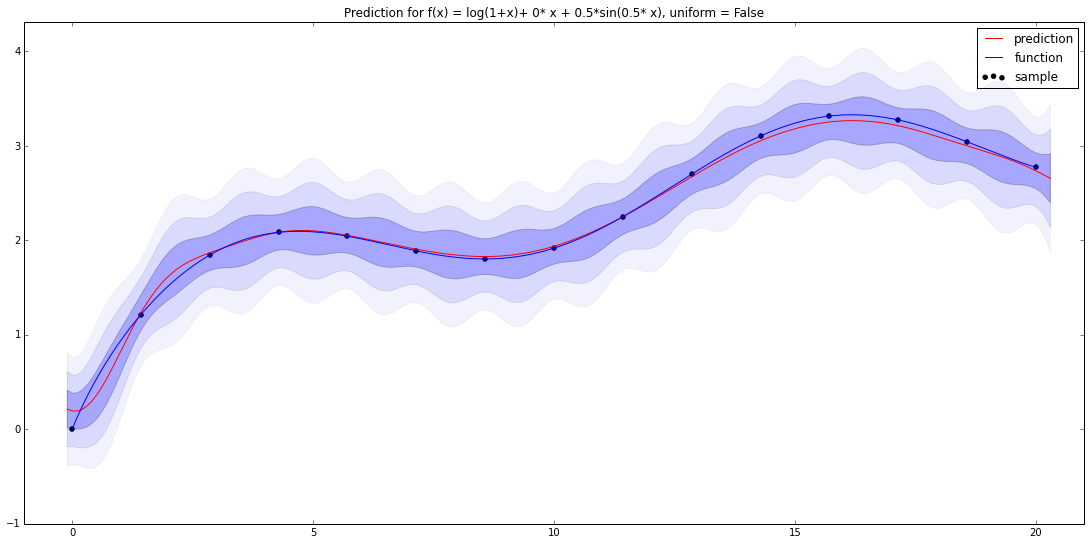

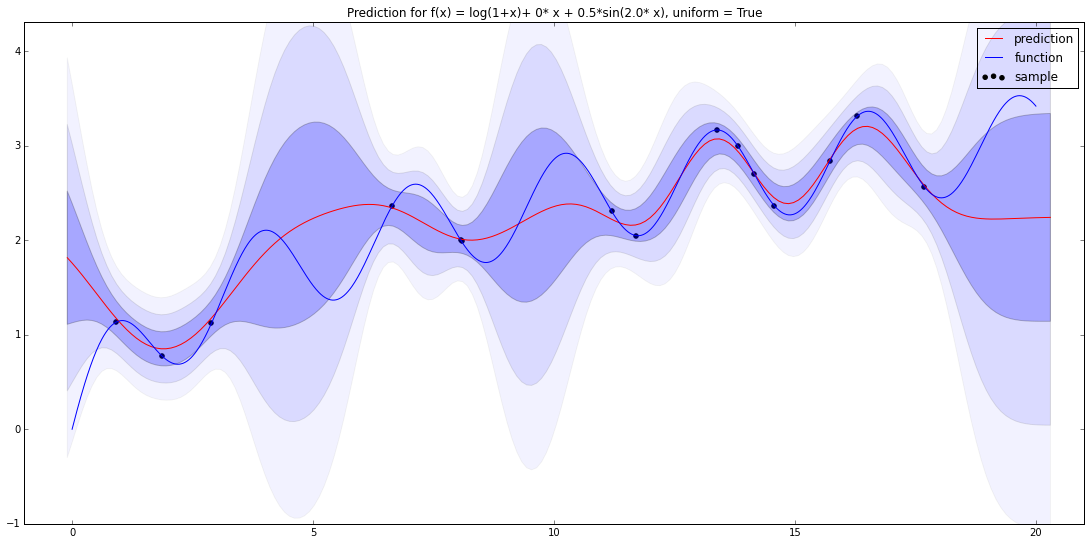

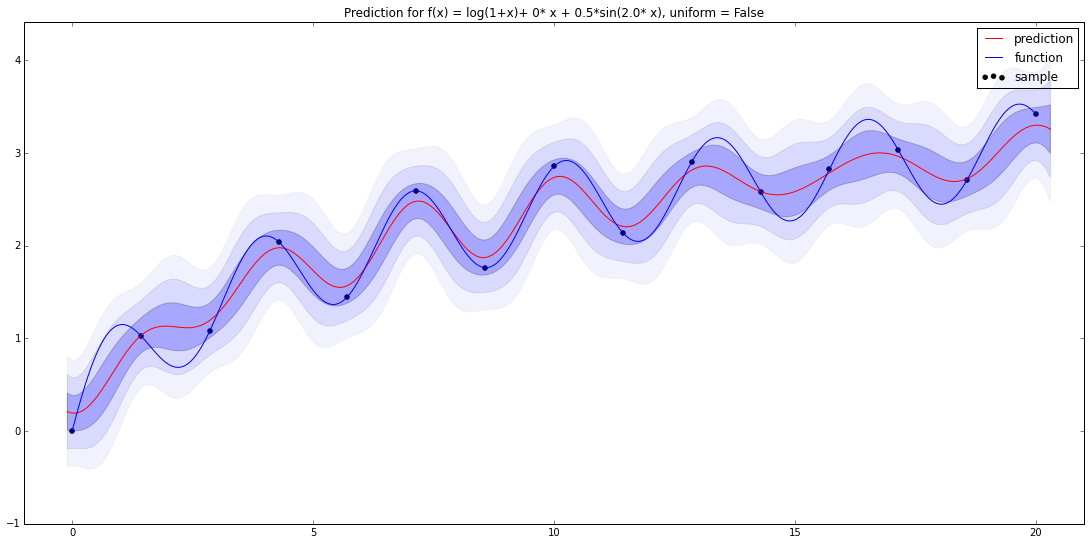

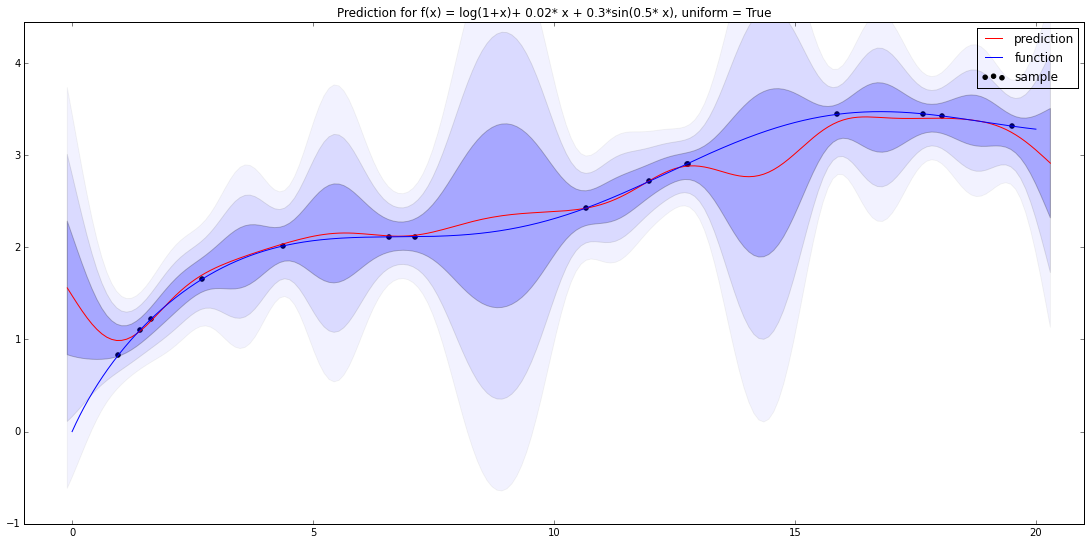

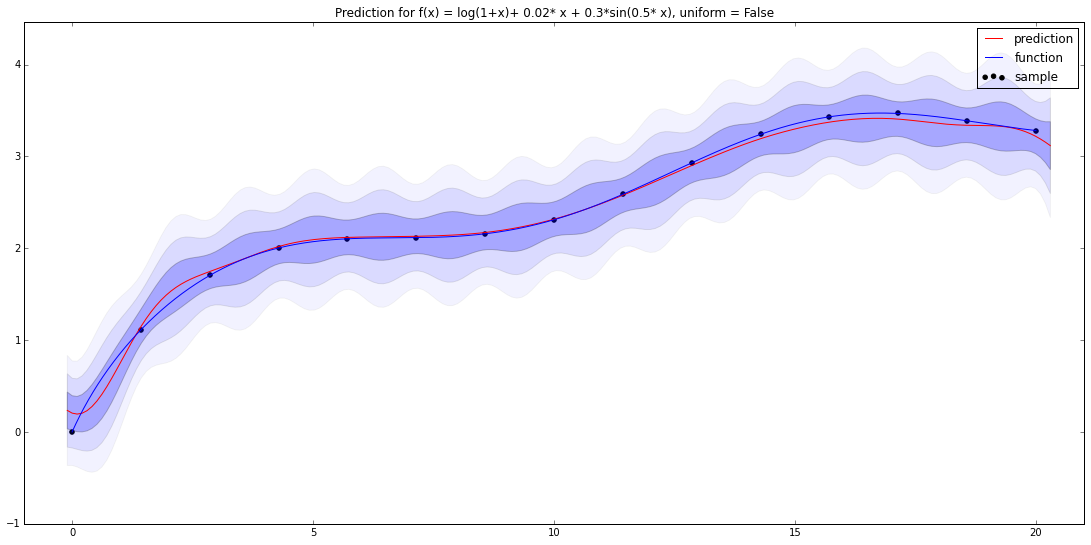

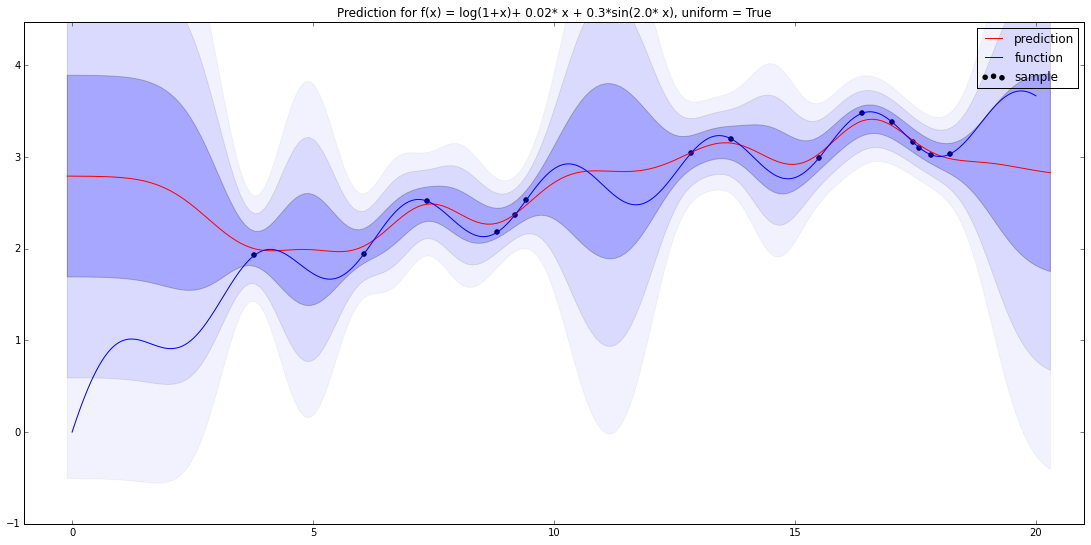

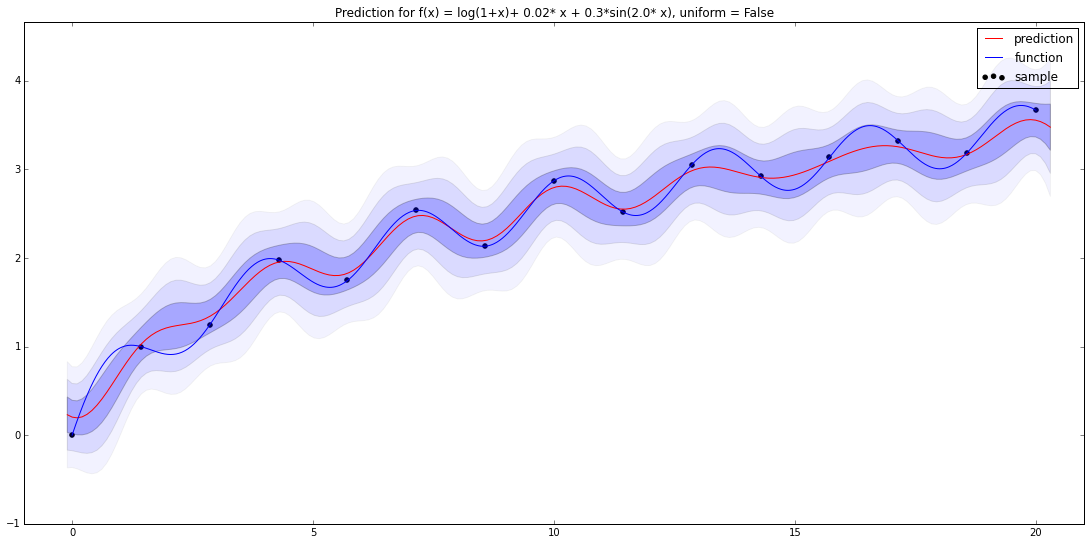

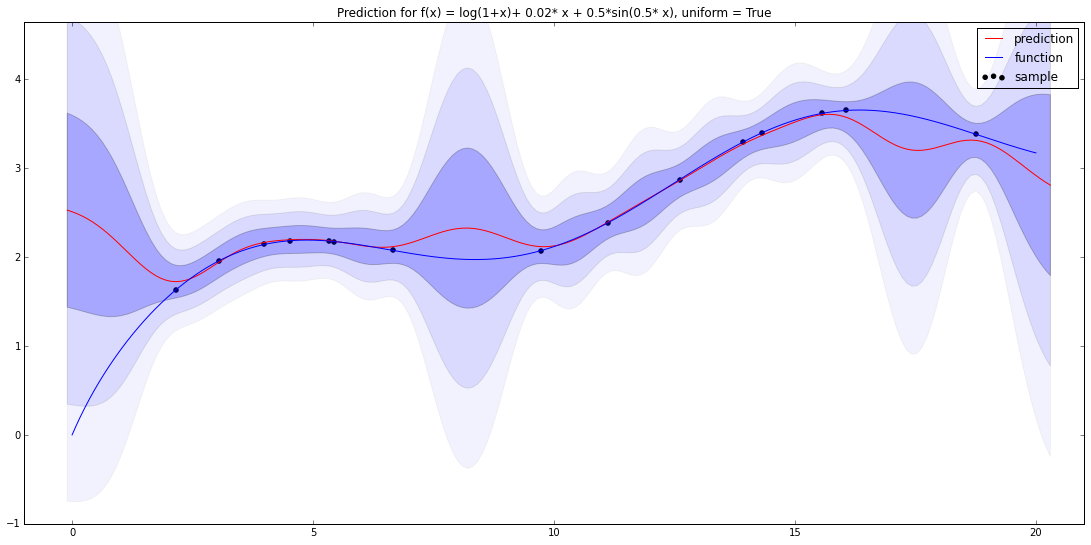

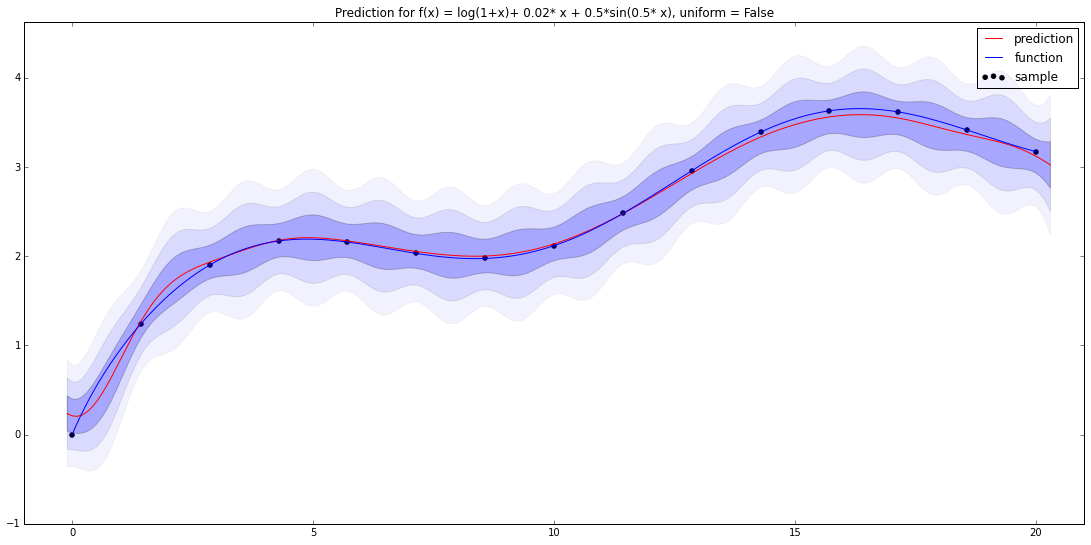

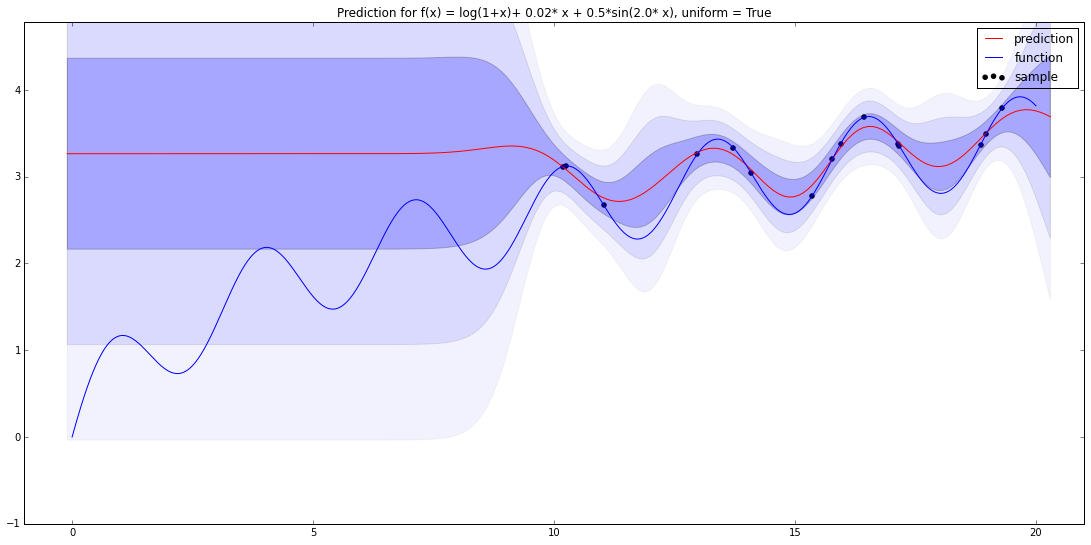

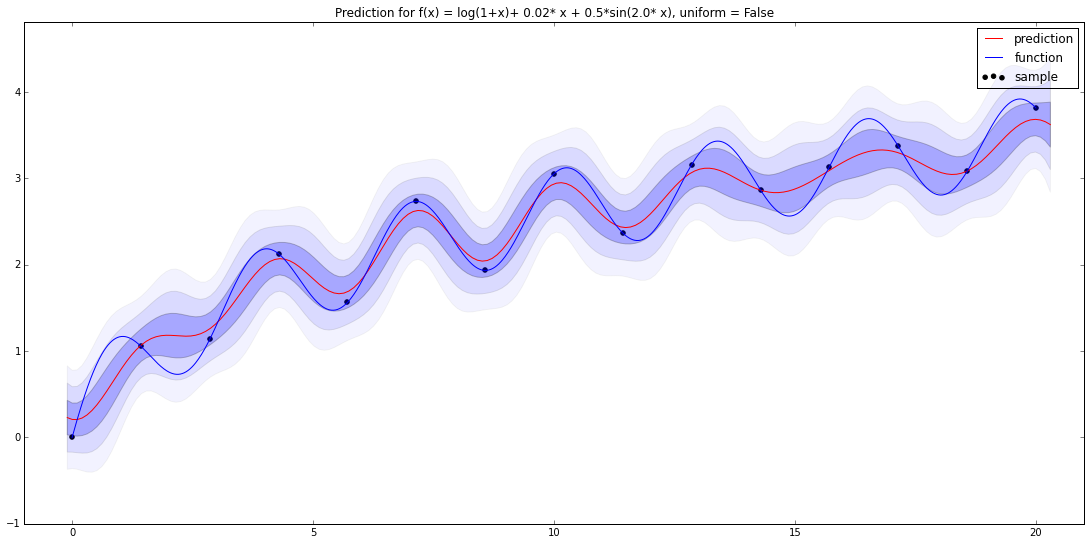

In [83]:
for a in [0, 0.02]:
    for b in [0.3, 0.5]:
        for c in [0.5, 2.]:
            for unif in [True, False]:
                show_graphic_with_prediction(15, 200, a, b, c, uniform=unif)

Видим, что выбор моментов времени через равные промежутки дает более оптимальный результат.

## Готовая реализация

Попробуем готовую реализацию из библиотеки sklearn.

In [23]:
from sklearn.gaussian_process import GaussianProcess

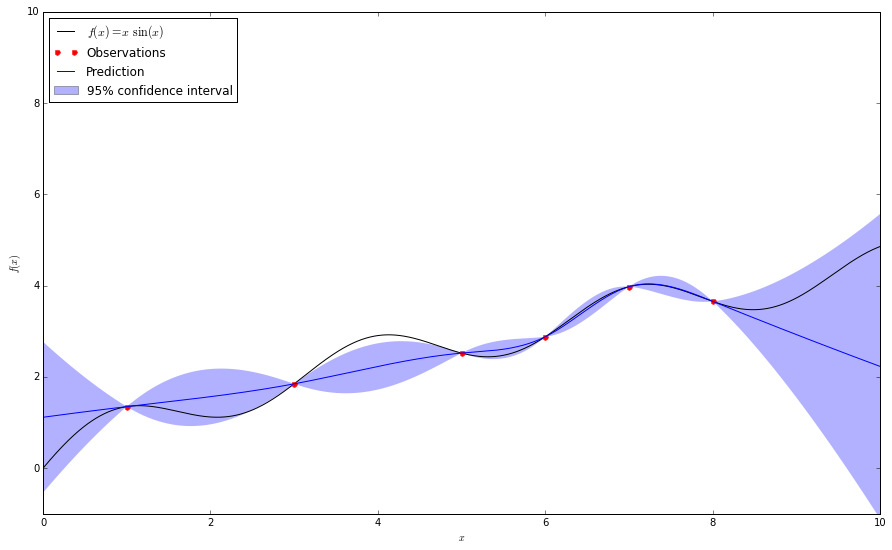

In [24]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = calc_f(X).ravel()
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)
gp.fit(X, y)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)
fig = plt.figure(figsize=(15,9))
plt.plot(x, calc_f(x), 'black', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.3, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-1, 10)
plt.legend(loc='upper left')
plt.show()

Видим, что готовая реализация тоже дает неплохой результат.

## С белым шумом

Теперь попробуем модель с белым шумом, то есть $f_{2}(x) = f(x) + \eta, \eta \sim \mathscr{N}(0, 0.1).$ Тогда новая матрица ковариаций связана со старой формулой: $\Sigma_2 = \Sigma + E.$ Нарисуем графики для этой модели.

In [95]:
def noise_f(x, a=0.2, b=0.5, c=2):
    return np.log(1 + x) + a * x + b * np.sin(c * x) + scs.norm.rvs(loc=0,scale=0.1,size=len(x))

def predict(X, T, t):
    
    def calc_mean(X, sigma):
        return -1. * np.sum(X * sigma[1:, 0])/sigma[0, 0]
    
    def calc_variance(sigma):
        return 1./sigma[0,0]

    mean = np.mean(X)
    X = X - mean
    n = len(T) + 1
    times = np.append([t], T)
    sigma = np.matrix(np.exp(-(times.reshape((len(times), 1)) - times) ** 2 / 2.)) + np.eye(n) * 0.1
    sigma = sigma.getI()
    return mean + calc_mean(X, sigma), calc_variance(sigma)

def noise_show_graphic_with_prediction(sample_size, prediction_size,a,b,c,function_precision=1000, uniform=True, scale=20):
    if uniform:
        T = scs.uniform.rvs(loc=0,scale=scale, size=sample_size)
    else:
        T = np.linspace(0, scale, sample_size)
    T_2 = np.linspace(-0.1, scale + 0.3, prediction_size) 
    X = noise_f(T,a=a,b=b,c=c)
    plt.figure(figsize=(19,9))
    plt.xlim((-1,scale+1))
    plt.ylim((-1, max(X) + 5))
    plt.scatter(T, X, color='black', label='sample')
    plt.plot(T_2, [predict(X, T, t)[0] for t in T_2], color='red', label='prediction')
    plt.fill_between(T_2, [predict(X, T, t)[0] - 3 * predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + 3 * predict(X, T, t)[1] for t in T_2], alpha=0.05, \
                     label='3 sigma confidence interval')
    plt.fill_between(T_2, [predict(X, T, t)[0] - 2 * predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + 2 * predict(X, T, t)[1] for t in T_2], alpha=0.1, \
                     label='2 sigma confidence interval')
    plt.fill_between(T_2, [predict(X, T, t)[0] - predict(X, T, t)[1] for t in T_2], \
         [predict(X, T, t)[0] + predict(X, T, t)[1] for t in T_2], alpha=0.23, label='1 sigma confidence interval')
    plt.plot(np.linspace(0, scale, function_precision), \
             calc_f(np.linspace(0, scale, function_precision),a=a,b=b,c=c),label='function') 
    plt.legend()
    title = "Prediction for f(x) = log(1+x)+ " + str(a) + "* x + " + str(b) + "*sin(" + str(c) + "* x)"
    plt.title(title +  " with noise(scale = 0.01), uniform = " + str(uniform))
    plt.show()

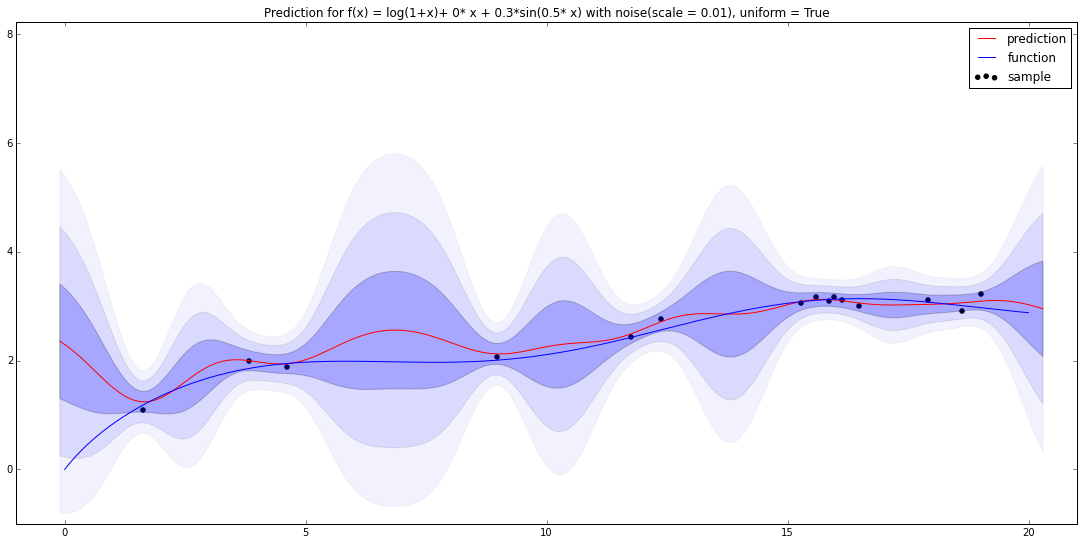

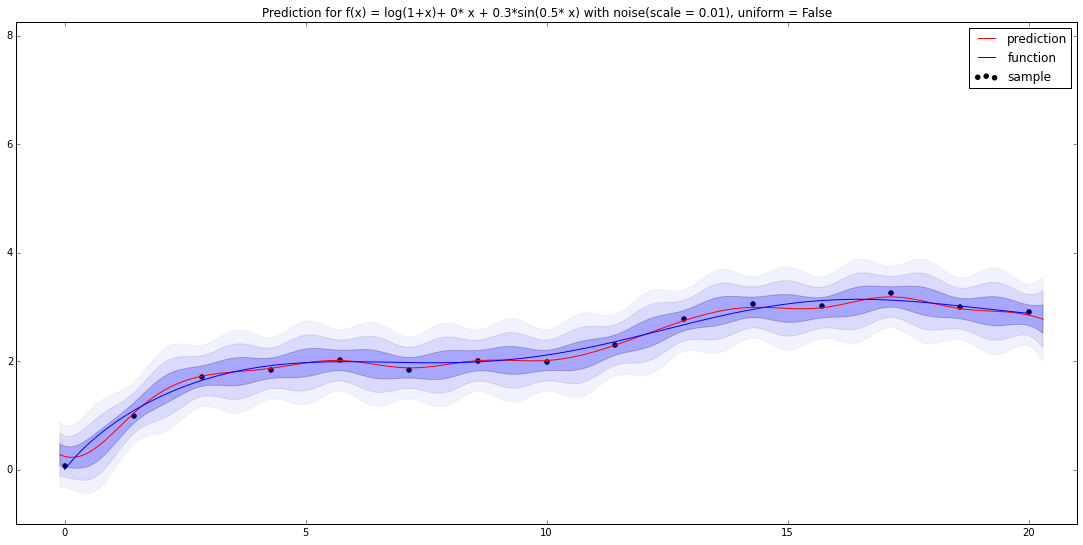

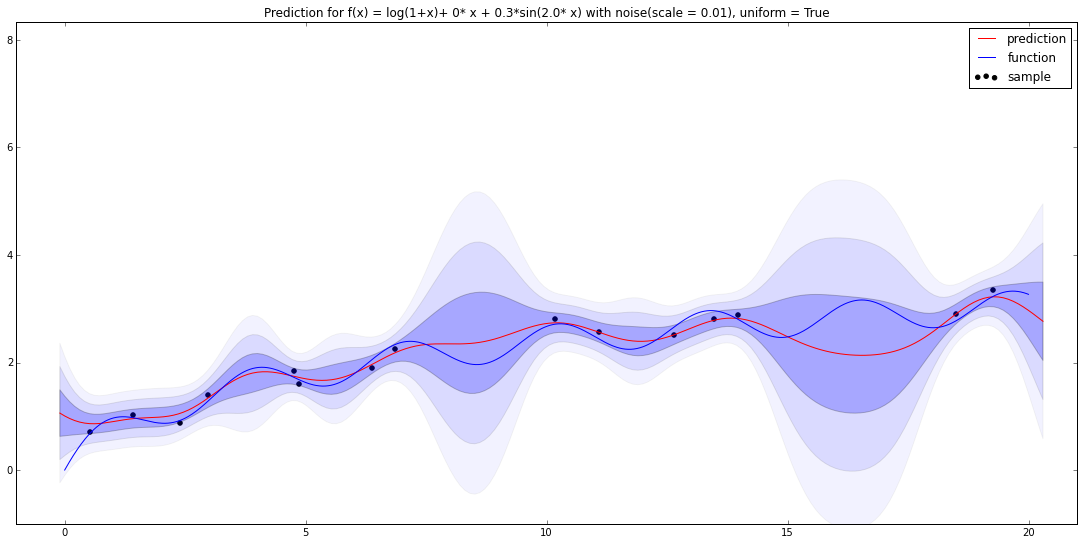

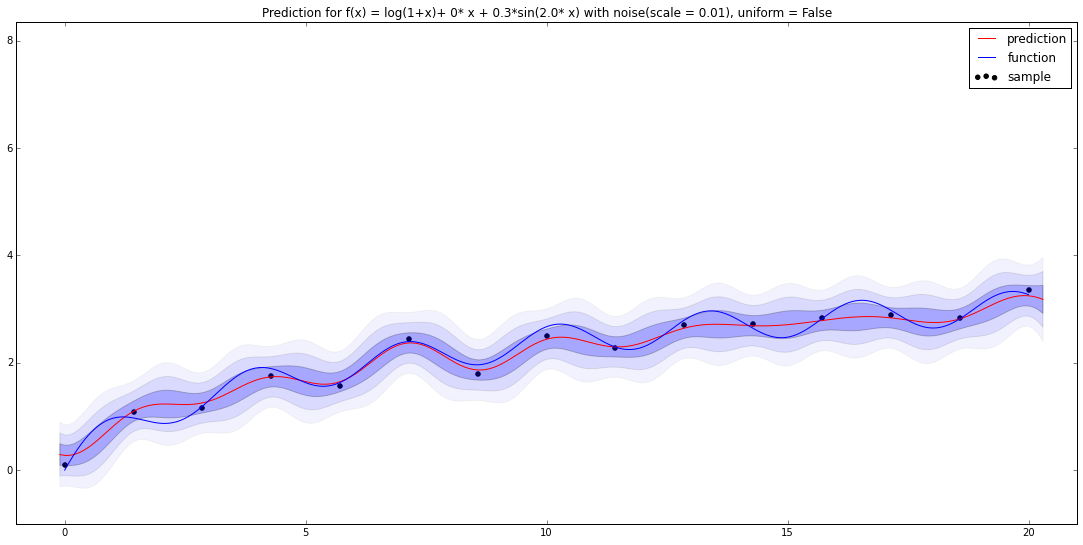

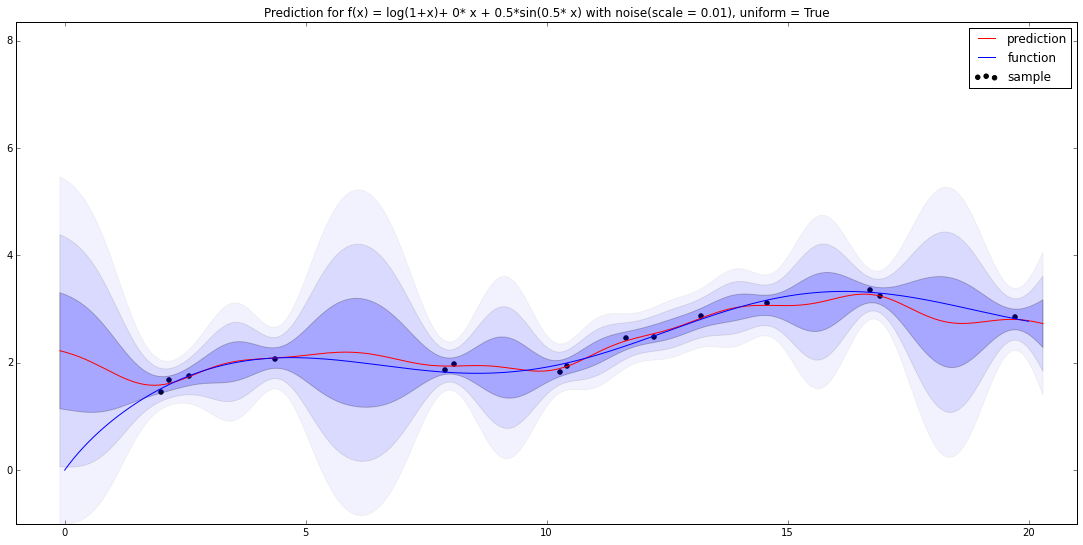

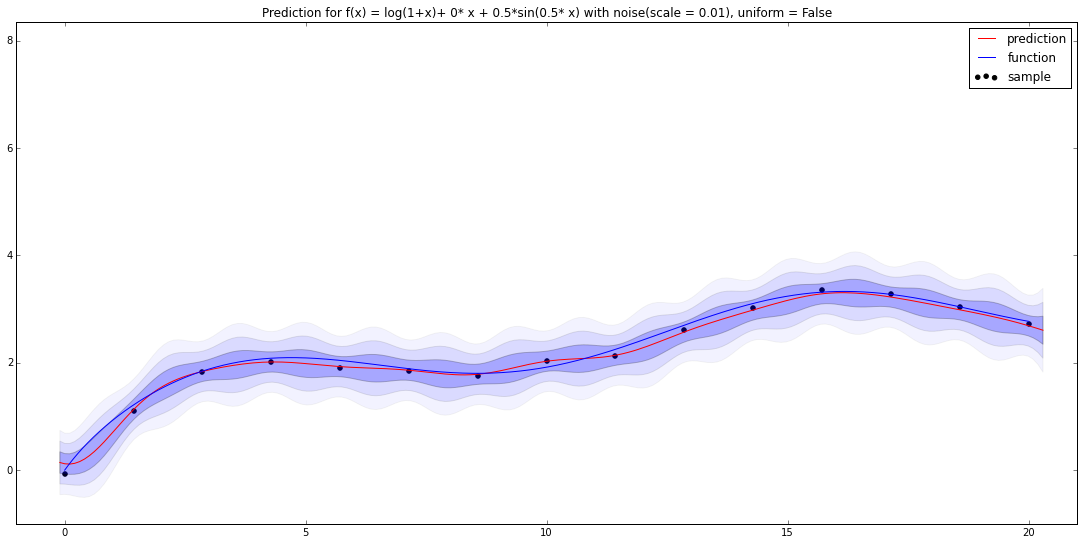

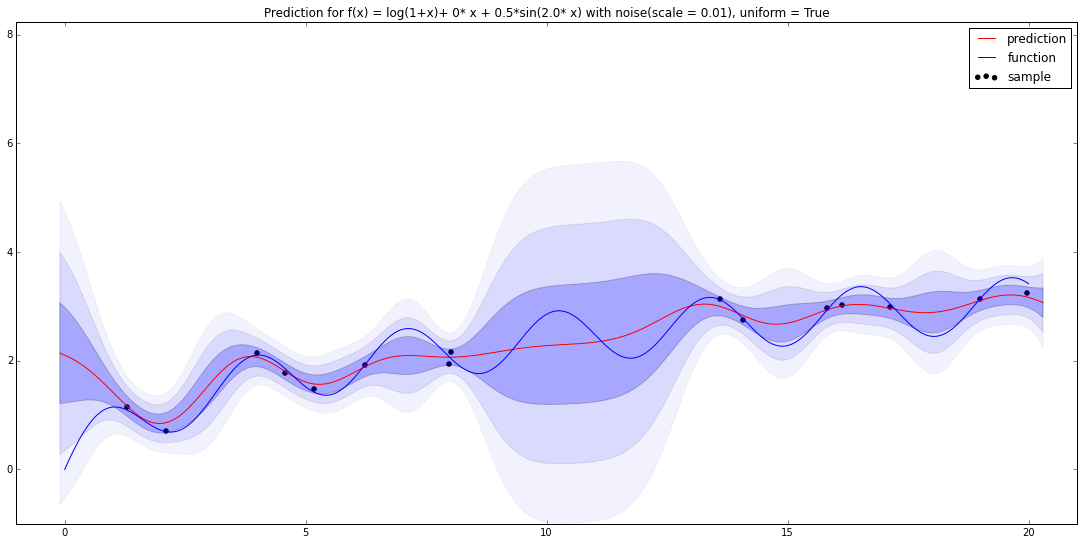

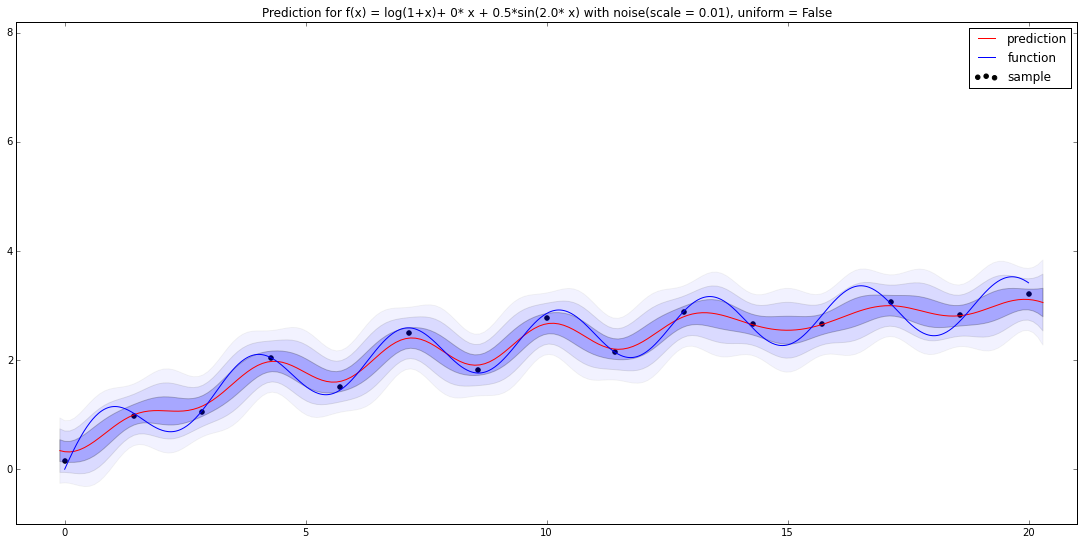

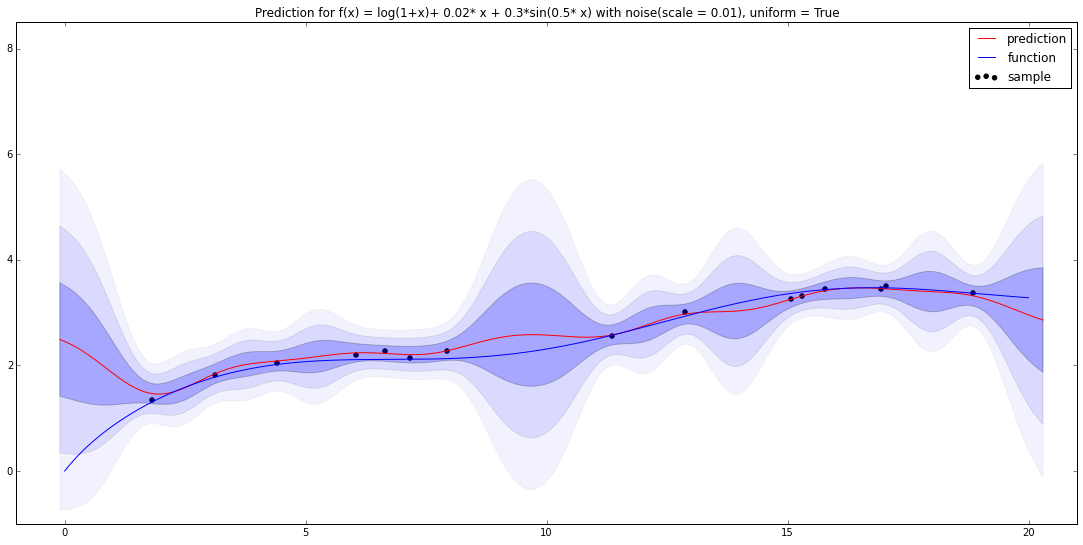

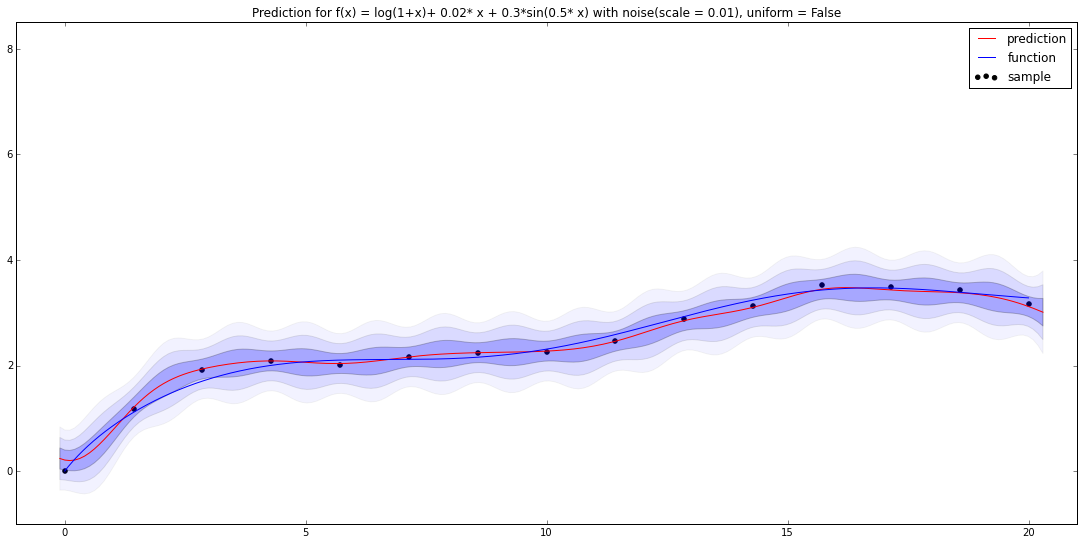

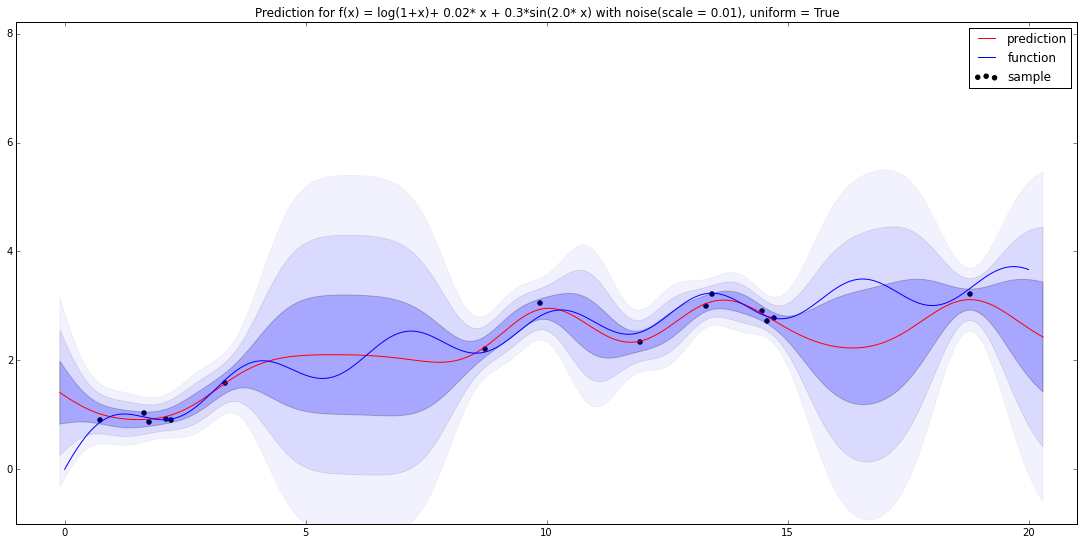

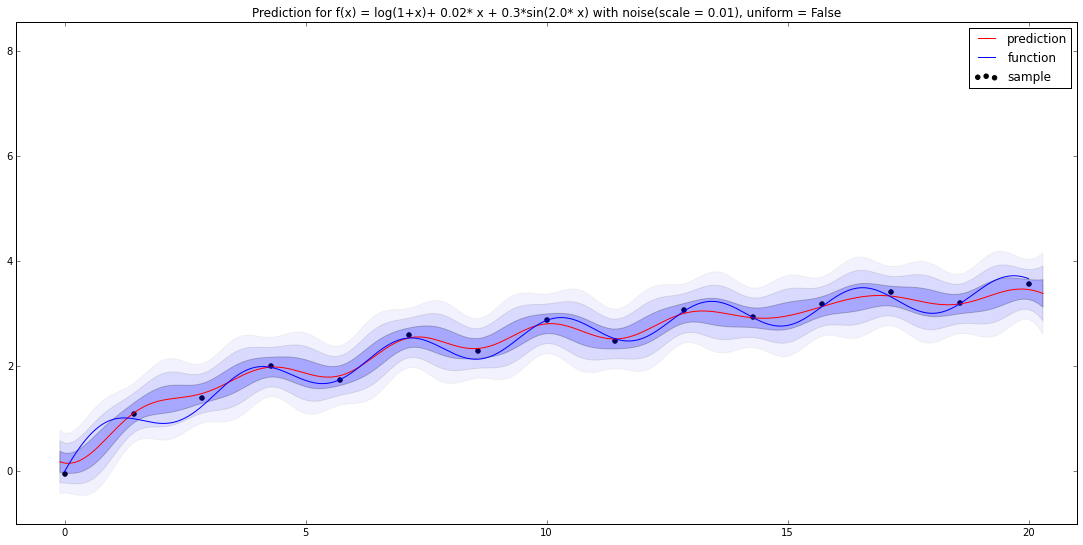

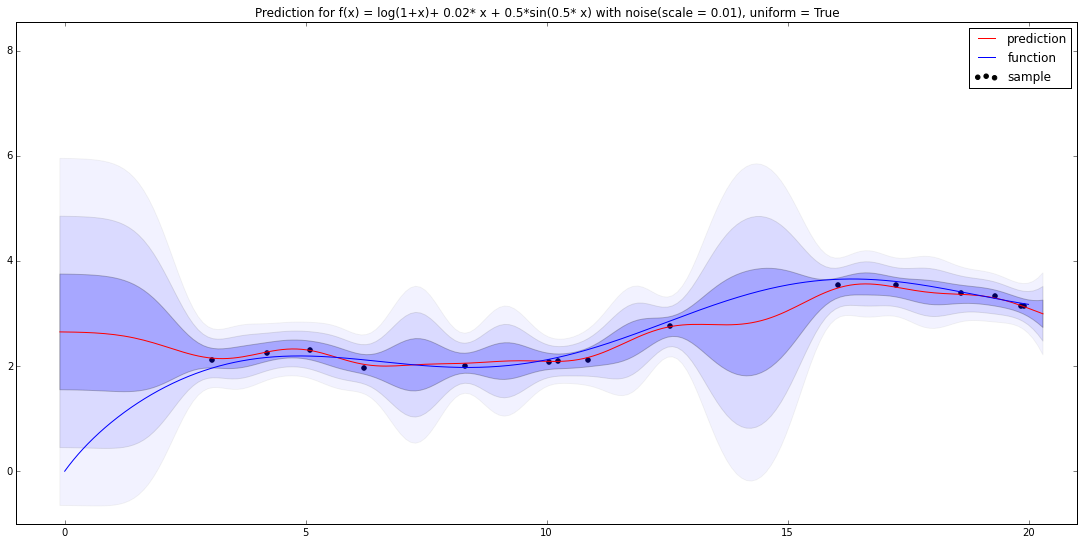

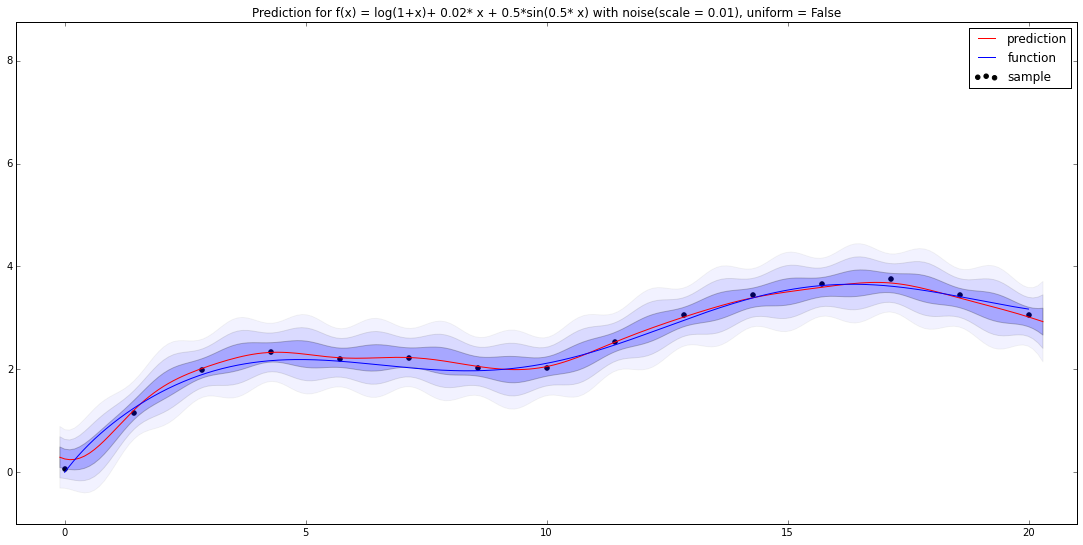

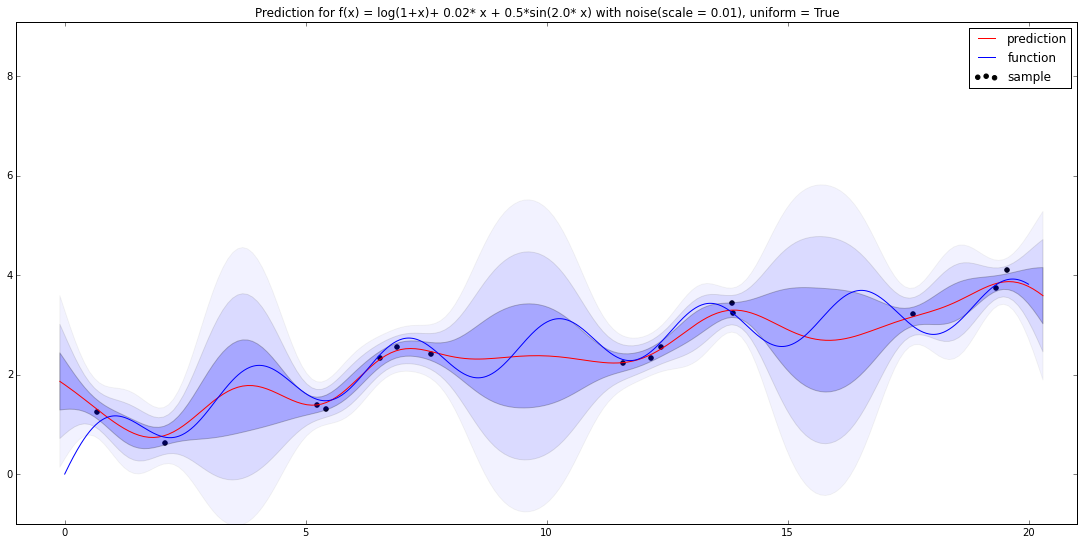

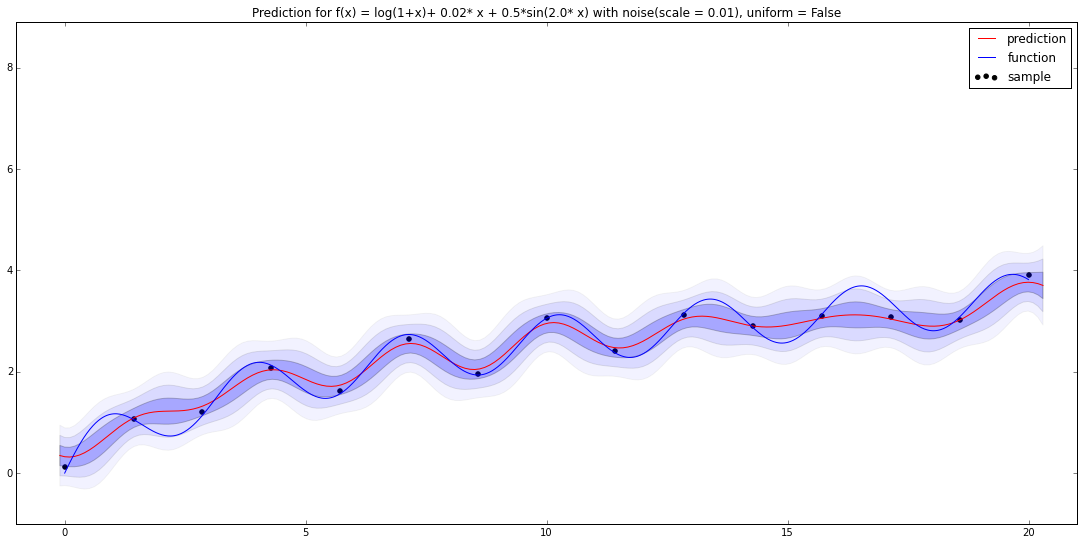

In [96]:
for a in [0, 0.02]:
    for b in [0.3, 0.5]:
        for c in [0.5, 2.]:
            for unif in [True, False]:
                noise_show_graphic_with_prediction(15, 200, a, b, c, uniform=unif)

Графики получились весьма правдоподобные. Аналогично первой модели оптимально выбирать моменты выборки через равные промежутки времени.

## Готовая реализация с белым шумом

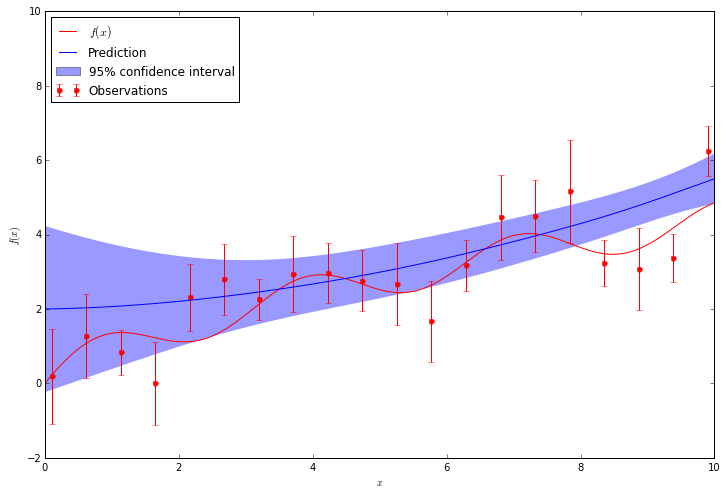

In [104]:
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = calc_f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
gp = GaussianProcess(corr='cubic', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=(dy / y) ** 2,
                     random_start=100)
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure(figsize=(12,8))
#plt.scatter(X, calc_f(X).ravel())
plt.plot(x, calc_f(x), 'r', label=u'$f(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.4, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2, 10)
plt.legend(loc='upper left')

plt.show()

В целом готовая реализация с белым шумом работает хуже моей.